In [120]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
from sklearn import svm
from imblearn.over_sampling import SMOTE



import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sylvie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sylvie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sylvie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# Import data
data = pd.read_csv('Dataset1_labeled_data.csv')

In [4]:
df1 = pd.read_csv('twitter_hate_speench_cleaned.csv')

In [5]:
gab = pd.read_csv('gab.csv')

In [10]:
# hate speech: 0
# offensive language: 1
# neither: 2

data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [11]:
# Check for NaN values:
data.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [12]:
# Size of dataset

data.shape
print('{} rows with {} columns'.format(data.shape[0],data.shape[1]))

24783 rows with 7 columns


In [13]:
# Distribution of Class
data['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [14]:
hate, offensive, neither = np.bincount(data['class'])
total = hate + offensive + neither
print(f'hate speech:\n    Total: {total}\n    hate: {hate} ({(100 * hate / total):.2f}% of total)\n')
print(f'offensive speech:\n    Total: {total}\n    Offensive: {offensive} ({(100 * offensive / total):.2f}% of total)\n')
print(f'neither:\n    Total: {total}\n    Neither: {neither} ({(100 * neither / total):.2f}% of total)\n')

hate speech:
    Total: 24783
    hate: 1430 (5.77% of total)

offensive speech:
    Total: 24783
    Offensive: 19190 (77.43% of total)

neither:
    Total: 24783
    Neither: 4163 (16.80% of total)



We have imbalanced dataset

In [6]:
df1 = df1[df1['label']==1][['label','tweet']]
df1


,label,tweet
0,1,@user #cnn calls #michigan middle school 'buil...
1,1,@user @user lumpy says i am a . prove it lumpy.
2,1,it's unbelievable that in the 21st century we'...
3,1,@user lets fight against #love #peace
4,1,ð©the white establishment can't have blk fol...
...,...,...
2230,1,lady banned from kentucky mall. @user #jcpenn...
2231,1,@user omfg i'm offended! i'm a mailbox and i'...
2232,1,@user @user you don't have the balls to hashta...
2233,1,"makes you ask yourself, who am i? then am i a..."


In [7]:
gab = gab[(gab['hate_speech_idx']=='[1]') | (gab['hate_speech_idx']=='[2]')][['hate_speech_idx','text']]
gab

,hate_speech_idx,text
0,[1],1. i joined gab to remind myself how retarded ...
2,[2],1. It makes you an asshole.\n2. \tGive it to a...
3,[2],1. So they manage to provide a whole lot of da...
5,[1],1. you sound like a faggot \n
7,[2],"1. Well, you are the fuckers that lit the matc..."
...,...,...
11818,[2],"1. A ""touching"" picture of Chelsea Handler and..."
11819,[1],1. Only a Demorat cocksucking pussy hating fag...
11820,[2],1. Remember this 3 months ago? The intern that...
11821,[2],1. #Sweden's four major dailies aftonbladet.se...


In [15]:
# Make a new column to highlight retweets
data['is_retweet'] = data['tweet'].apply(lambda x: x[:2]=='RT')
data['is_retweet'].sum()  # number of retweets

6484

In [16]:
# number of unique retweets
data.loc[data['is_retweet']].tweet.unique().size

6484

### Extracting substrings (@, #)

In [9]:
# Who is being retweeted?
# Who is being tweeted at/mentioned?
# What hashtags are being used?

# Create functions

def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   

In [17]:
# Make new columns for retweeted usernames, mentioned usernames and hashtags

data['retweeted'] = data.tweet.apply(find_retweeted)
data['mentioned'] = data.tweet.apply(find_mentioned)
data['hashtags'] = data.tweet.apply(find_hashtags)

In [18]:
# Have a look at the new columns

data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,is_retweet,retweeted,mentioned,hashtags
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,False,[@mayasolovely],[],[]
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,False,[@mleew17],[],[]
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,False,[@UrKindOfBrand],[],[]
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,False,[@C_G_Anderson],[@viva_based],[]
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,False,[@ShenikaRoberts],[],[]


#### What hashtags are being used 

In [ ]:
# Take the rows from the hashtag columns where there are actually hashtags

hashtags_list_data = data.loc[
                       data.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]
hashtags_list_data.head()

,hashtags
37,[#Shots]
41,[#SevenOne]
45,[#HappyHumpDay]
72,[#ahmesehwetness]
73,"[#Eaglesnation, #Eagles]"


In [ ]:
# Create dataframe where each use of hashtag gets its own row

flattened_hashtags_data = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_data.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
flattened_hashtags_data.head()

,hashtag
0,#Shots
1,#SevenOne
2,#HappyHumpDay
3,#ahmesehwetness
4,#Eaglesnation


In [ ]:
flattened_hashtags_data.shape

(3490, 1)

In [ ]:
# Number of unique hashtags

flattened_hashtags_data['hashtag'].unique().size

2251

In [ ]:
# Count of appearances of each hashtag
popular_hashtags = flattened_hashtags_data.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_hashtags.head(10)

,hashtag,counts
0,#Yankees,94
1,#iphone,50
2,#ipad,48
3,#sex,48
4,#android,48
5,#porn,48
6,#xxx,48
7,#tcot,41
8,#hoosiers,23
9,#morningjoe,22


#### Who is being retweeted 

In [ ]:
# Take the rows from the retweeted columns where there are actually hashtags

retweeted_list_data = data.loc[
                       data.retweeted.apply(
                           lambda retweeted_list: retweeted_list !=[]
                       ),['retweeted']]
retweeted_list_data.head()


,retweeted
0,[@mayasolovely]
1,[@mleew17]
2,[@UrKindOfBrand]
3,[@C_G_Anderson]
4,[@ShenikaRoberts]


In [ ]:
# Create dataframe where each use of retweeted gets its own row

flattened_retweeted_data = pd.DataFrame(
    [retweeted for retweeted_list in retweeted_list_data.retweeted
    for retweeted in retweeted_list],
    columns=['retweeted'])
flattened_retweeted_data.head()


,retweeted
0,@mayasolovely
1,@mleew17
2,@UrKindOfBrand
3,@C_G_Anderson
4,@ShenikaRoberts


In [ ]:
flattened_retweeted_data.shape

(7073, 1)

In [ ]:
# Number of unique retweeted

flattened_retweeted_data['retweeted'].unique().size

5296

In [ ]:
# Count of appearances of each retweeted
popular_retweeted = flattened_retweeted_data.groupby('retweeted').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_retweeted.head(10)

,retweeted,counts
0,@iDntWearCondoms,25
1,@Yankees,24
2,@JoeBudden,23
3,@CauseWereGuys,22
4,@KINGTUNCHI_,19
5,@FriendlyAssh0le,19
6,@KingHorseDick,19
7,@FunnyPicsDepot,15
8,@CuhCuhCuh,15
9,@SteveStfler,14


#### Who is being tweeted at/mentioned

In [ ]:
# Take the rows from the mentioned columns where there are actually hashtags

mentioned_list_data = data.loc[
                       data.mentioned.apply(
                           lambda mentioned_list: mentioned_list !=[]
                       ),['mentioned']]
mentioned_list_data.head()



,mentioned
3,[@viva_based]
5,[@T_Madison_x]
7,[@selfiequeenbri]
9,[@rhythmixx_]
52,[@DaRealKha]


In [ ]:
# Create dataframe where each use of mentioned gets its own row

flattened_mentioned_data = pd.DataFrame(
    [mentioned for mentioned_list in mentioned_list_data.mentioned
    for mentioned in mentioned_list],
    columns=['mentioned'])
flattened_mentioned_data.head()

,mentioned
0,@viva_based
1,@T_Madison_x
2,@selfiequeenbri
3,@rhythmixx_
4,@DaRealKha


In [ ]:
flattened_mentioned_data.shape

(10958, 1)

In [ ]:
# Number of unique retweeted

flattened_mentioned_data['mentioned'].unique().size

7039

In [ ]:
# Count of appearances of each retweeted
popular_mentioned = flattened_mentioned_data.groupby('mentioned').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_mentioned.head(10)

,mentioned,counts
0,@kieffer_jason,101
1,@Yankees,46
2,@Huntermoore,30
3,@Buckm00se,23
4,@sbsylvester,22
5,@what_evaittakes,20
6,@VoiceOfDStreetz,19
7,@JawShoeeAhhh,18
8,@Leelucas_,18
9,@viaNAWF,18


### Wordcloud for 3 categories of tweets

<class 'set'>


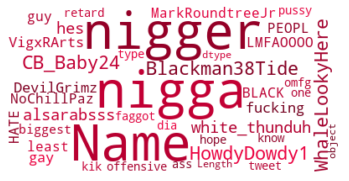

In [ ]:
# Hate Speech

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

print(type(STOPWORDS))

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(data.loc[data["class"]== 0].tweet))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

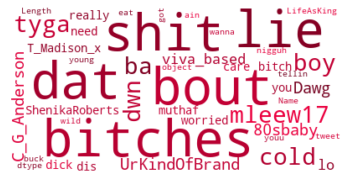

In [ ]:
# Offensive Language 

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(data.loc[data["class"]== 1].tweet))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

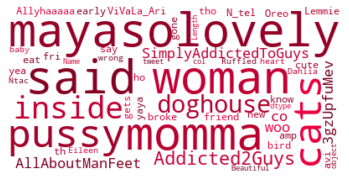

In [ ]:
# Neither

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(data.loc[data["class"]== 2].tweet))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

### Cleaning Unstructured Text Data

In [8]:
# Create functions

def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z0-9-_]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z0-9-_]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [9]:
my_stopwords = nltk.corpus.stopwords.words('english')
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]\\\\\^_`{|}~•@#'

# cleaning master function
def clean_tweet(tweet):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet = re.sub('amp', '', tweet) # remove amp
    tweet = re.sub(r'\s+', ' ', tweet) #remove double spacing
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords
    lemmatizer = WordNetLemmatizer() 
    tweet_token_list = [lemmatizer.lemmatize(word) # if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    tweet = ' '.join(tweet_token_list)
    return tweet

In [10]:
data['clean_tweet'] = data.tweet.apply(clean_tweet)
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain cleaning house man always take...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st p...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confused shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya


In [11]:
df1['clean_tweet'] = df1.tweet.apply(clean_tweet)
df1

,label,tweet,clean_tweet
0,1,@user #cnn calls #michigan middle school 'buil...,cnn call michigan middle school build wall ch...
1,1,@user @user lumpy says i am a . prove it lumpy.,lumpy say prove lumpy
2,1,it's unbelievable that in the 21st century we'...,unbelievable st century need something like ne...
3,1,@user lets fight against #love #peace,let fight love peace
4,1,ð©the white establishment can't have blk fol...,ð©the white establishment blk folx running a...
...,...,...,...
2230,1,lady banned from kentucky mall. @user #jcpenn...,ady banned kentucky mall jcpenny kentucky
2231,1,@user omfg i'm offended! i'm a mailbox and i'...,omfg offended mailbox proud mailboxpride libe...
2232,1,@user @user you don't have the balls to hashta...,ball hashtag say weasel away lumpy tony dipshit
2233,1,"makes you ask yourself, who am i? then am i a...",make ask anybody god oh thank god


In [12]:
gab['clean_tweet'] = gab.text.apply(clean_tweet)
gab

,hate_speech_idx,text,clean_tweet
0,[1],1. i joined gab to remind myself how retarded ...,joined gab remind retarded jew hater typing a...
2,[2],1. It makes you an asshole.\n2. \tGive it to a...,make asshole give soldier defend try burn sho...
3,[2],1. So they manage to provide a whole lot of da...,manage provide whole lot data except critical...
5,[1],1. you sound like a faggot \n,sound like faggot
7,[2],"1. Well, you are the fuckers that lit the matc...",well fucker lit match fakepatriots lock racis...
...,...,...,...
11818,[2],"1. A ""touching"" picture of Chelsea Handler and...",touching picture chelsea handler dad wow mora...
11819,[1],1. Only a Demorat cocksucking pussy hating fag...,demorat cocksucking pussy hating faggot would...
11820,[2],1. Remember this 3 months ago? The intern that...,remember month ago intern yelled obscenity pr...
11821,[2],1. #Sweden's four major dailies aftonbladet.se...,sweden four major daily aftonbladet se dn se ...


In [13]:
df1['label'] = 0
df1.rename(columns = {'label': 'class'}, inplace = True)
df1

,class,tweet,clean_tweet
0,0,@user #cnn calls #michigan middle school 'buil...,cnn call michigan middle school build wall ch...
1,0,@user @user lumpy says i am a . prove it lumpy.,lumpy say prove lumpy
2,0,it's unbelievable that in the 21st century we'...,unbelievable st century need something like ne...
3,0,@user lets fight against #love #peace,let fight love peace
4,0,ð©the white establishment can't have blk fol...,ð©the white establishment blk folx running a...
...,...,...,...
2230,0,lady banned from kentucky mall. @user #jcpenn...,ady banned kentucky mall jcpenny kentucky
2231,0,@user omfg i'm offended! i'm a mailbox and i'...,omfg offended mailbox proud mailboxpride libe...
2232,0,@user @user you don't have the balls to hashta...,ball hashtag say weasel away lumpy tony dipshit
2233,0,"makes you ask yourself, who am i? then am i a...",make ask anybody god oh thank god


In [14]:
gab['hate_speech_idx'] = 0
gab.rename(columns = {'hate_speech_idx': 'class'}, inplace = True)
gab

,class,text,clean_tweet
0,0,1. i joined gab to remind myself how retarded ...,joined gab remind retarded jew hater typing a...
2,0,1. It makes you an asshole.\n2. \tGive it to a...,make asshole give soldier defend try burn sho...
3,0,1. So they manage to provide a whole lot of da...,manage provide whole lot data except critical...
5,0,1. you sound like a faggot \n,sound like faggot
7,0,"1. Well, you are the fuckers that lit the matc...",well fucker lit match fakepatriots lock racis...
...,...,...,...
11818,0,"1. A ""touching"" picture of Chelsea Handler and...",touching picture chelsea handler dad wow mora...
11819,0,1. Only a Demorat cocksucking pussy hating fag...,demorat cocksucking pussy hating faggot would...
11820,0,1. Remember this 3 months ago? The intern that...,remember month ago intern yelled obscenity pr...
11821,0,1. #Sweden's four major dailies aftonbladet.se...,sweden four major daily aftonbladet se dn se ...


In [15]:
bigdata = pd.concat([data, df1,gab], ignore_index=True, sort=False)
bigdata

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet,text
0,0.0,3.0,0.0,0.0,3.0,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain cleaning house man always take...,NaN
1,1.0,3.0,0.0,3.0,0.0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st p...,NaN
2,2.0,3.0,0.0,3.0,0.0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confused shit,NaN
3,3.0,3.0,0.0,2.0,1.0,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny,NaN
4,4.0,6.0,0.0,6.0,0.0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya,NaN
...,...,...,...,...,...,...,...,...,...
34320,NaN,NaN,NaN,NaN,NaN,0,NaN,touching picture chelsea handler dad wow mora...,"1. A ""touching"" picture of Chelsea Handler and..."
34321,NaN,NaN,NaN,NaN,NaN,0,NaN,demorat cocksucking pussy hating faggot would...,1. Only a Demorat cocksucking pussy hating fag...
34322,NaN,NaN,NaN,NaN,NaN,0,NaN,remember month ago intern yelled obscenity pr...,1. Remember this 3 months ago? The intern that...
34323,NaN,NaN,NaN,NaN,NaN,0,NaN,sweden four major daily aftonbladet se dn se ...,1. #Sweden's four major dailies aftonbladet.se...


In [27]:
hate, offensive, neither = np.bincount(bigdata['class'])
total = hate + offensive + neither
print(f'hate speech:\n    Total: {total}\n    hate: {hate} ({(100 * hate / total):.2f}% of total)\n')
print(f'offensive speech:\n    Total: {total}\n    Offensive: {offensive} ({(100 * offensive / total):.2f}% of total)\n')
print(f'neither:\n    Total: {total}\n    Neither: {neither} ({(100 * neither / total):.2f}% of total)\n')

hate speech:
    Total: 34325
    hate: 10972 (31.97% of total)

offensive speech:
    Total: 34325
    Offensive: 19190 (55.91% of total)

neither:
    Total: 34325
    Neither: 4163 (12.13% of total)



## Test traditional models

In [16]:
df = bigdata['clean_tweet']
target = bigdata['class']

In [17]:
# Tokenizing
# function to tokenize 

def unfiltered_tokens(text):
    dirty_tokens = nltk.word_tokenize(text)
    return dirty_tokens

In [18]:
# applying this function to the `clean_tweets` column

processed_data = list(map(unfiltered_tokens, df))

In [19]:
# morphing `processed_data` into a readable list

flat_unfiltered = [item for sublist in processed_data for item in sublist]

In [20]:
# getting frequency distribution
corpus_freqdist = FreqDist(flat_unfiltered)

# top 20 words in the corpus
corpus_freqdist.most_common(20)

[('bitch', 11805),
 ('like', 4381),
 ('hoe', 4356),
 ('nigger', 3367),
 ('get', 2514),
 ('pussy', 2361),
 ('faggot', 2322),
 ('u', 2110),
 ('fuck', 2080),
 ('nigga', 2025),
 ('shit', 1987),
 ('got', 1958),
 ('as', 1914),
 ('cunt', 1819),
 ('white', 1733),
 ('one', 1623),
 ('’', 1469),
 ('retarded', 1461),
 ('people', 1440),
 ('know', 1413)]

In [21]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

# Our corpus has a vocabulary of 17963. 
# This would also be the number of columns in the sparse matrix after we vectorize the data later.

31612

In [22]:
# Lemmatization: it reduces each word into a linguistically valid lemma, or root word. 
# It does this through linguistic mappings, using the WordNet lexical database.

# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [23]:
X_lem = lemmatized_output
y_lem = target

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.2, random_state= 20)

# using tf_idf vectorizor
tfidf = TfidfVectorizer()

In [25]:
# sparse matrix format with 15671 stored elements
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

In [26]:
# taking a quick look of the non zero elements
non_zero_cols = tfidf_data_train.nnz / float(tfidf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

# 99.9% of the columns contain a zero, meaning that's a very sparse matrix

Average Number of Non-Zero Elements in Vectorized Articles: 9.959978150036417
Percentage of columns containing ZERO: 0.9996376344993801


In [27]:
# creating single df for training set
X_train_df = pd.DataFrame(data=tfidf_data_train, index=None, columns=['clean_tweet']) 
y_train_df = pd.DataFrame(data=y_train, index=None, columns=['class']) 
# joining them
training = pd.concat([X_train_df, y_train_df], axis=1)

In [29]:
# separate minority and majority classes
hate = training[training['class']==0]
offensive = training[training['class']==1]
neither = training[training['class']==2]


In [30]:
print(hate.shape)
print(offensive.shape)
print(neither.shape)

(8810, 2)
(15306, 2)
(3344, 2)


We can see that this data has a huge class imbalance. After running a baseline, we can try oversampling the minority class (hate speech) with SMOTE and undersampling the majority class with Tomek Links.

### Baseline Random Forest

In [46]:
rf_baseline = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)
# adding class_weight='balanced' increased accuracy & precision but decreased F1

In [47]:
rf_baseline.fit(tfidf_data_train, y_train)
rf_test_preds = rf_baseline.predict(tfidf_data_test)

rf_baseline_report = classification_report(y_test, rf_test_preds)
print(rf_baseline_report)

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2162
           1       0.93      0.91      0.92      3884
           2       0.76      0.80      0.78       819

    accuracy                           0.89      6865
   macro avg       0.85      0.86      0.86      6865
weighted avg       0.89      0.89      0.89      6865



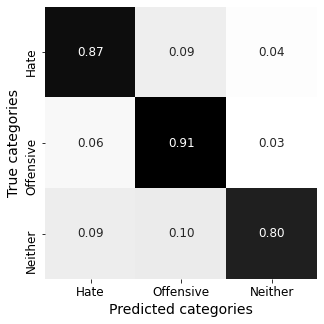

In [48]:
import seaborn
conf_matrix = confusion_matrix(y_test, rf_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [79]:
# function to print all evaluation metrics
def evaluation(precision, recall, f1_score):
    """prints out evaluation metrics for a model"""
    print('Testing Set Evaluation Metrics:')
    print('Precision: {:.3}'.format(precision))
    print('Recall: {:.3}'.format(recall))
    print('F1 Score: {:.3}'.format(f1_score))

In [80]:
rf_precision = precision_score(y_test, rf_test_preds,average='weighted')
rf_recall = recall_score(y_test, rf_test_preds,average='weighted')
rf_f1_score = f1_score(y_test, rf_test_preds,average='weighted')


# printing scores
evaluation(rf_precision, rf_recall, rf_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.887
Recall: 0.885
F1 Score: 0.886


In [135]:
# creating dictionary to store all metrics
metric_dict = {}
# adding scores to metric_dict
metric_dict['Baseline Random Forest'] = {'Precision': rf_precision, 'Recall': rf_recall, 'F1_score': rf_f1_score}

### Baseline Logistic Regression

In [31]:
logreg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)

In [32]:
logreg_baseline.fit(tfidf_data_train, y_train)
logreg_test_preds = logreg_baseline.predict(tfidf_data_test)

logreg_baseline_report = classification_report(y_test, logreg_test_preds)
print(logreg_baseline_report)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      2162
           1       0.96      0.87      0.91      3884
           2       0.71      0.91      0.80       819

    accuracy                           0.88      6865
   macro avg       0.84      0.89      0.86      6865
weighted avg       0.89      0.88      0.89      6865



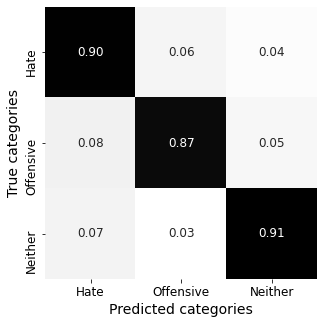

In [33]:
conf_matrix = confusion_matrix(y_test, logreg_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [83]:
log_reg_precision = precision_score(y_test, logreg_test_preds,average='weighted')
log_reg_recall = recall_score(y_test, logreg_test_preds,average='weighted')
log_reg_f1_score = f1_score(y_test, logreg_test_preds,average='weighted')


# printing scores
evaluation(log_reg_precision, log_reg_recall, log_reg_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.893
Recall: 0.883
F1 Score: 0.885


In [136]:
# adding scores to metric_dict

metric_dict['Baseline Logistic Regression'] = {'Precision': log_reg_precision, 'Recall': log_reg_recall, 'F1_score': log_reg_f1_score}

### Baseline with SMOTE

In [34]:
sm = SMOTE(random_state=35)
smote_X_train, smote_y_train = sm.fit_sample(tfidf_data_train, y_train)

In [35]:
smote_logreg = LogisticRegression(penalty='l2', random_state=35)

smote_logreg.fit(smote_X_train, smote_y_train)
smote_logreg_test_preds = smote_logreg.predict(tfidf_data_test)

smote_logreg_report = classification_report(y_test, smote_logreg_test_preds)
print(smote_logreg_report)

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      2162
           1       0.95      0.88      0.91      3884
           2       0.71      0.90      0.80       819

    accuracy                           0.88      6865
   macro avg       0.84      0.89      0.86      6865
weighted avg       0.89      0.88      0.88      6865



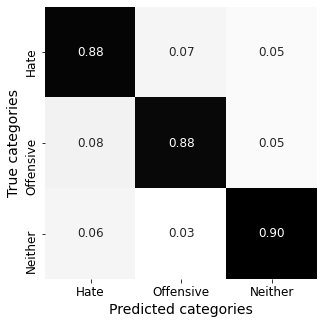

In [36]:
conf_matrix = confusion_matrix(y_test, smote_logreg_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [110]:
smote_logreg_precision = precision_score(y_test, smote_logreg_test_preds,average='weighted')
smote_logreg_recall = recall_score(y_test, smote_logreg_test_preds,average='weighted')
smote_logreg_f1_score = f1_score(y_test, smote_logreg_test_preds,average='weighted')


# printing scores
evaluation(smote_logreg_precision, smote_logreg_recall, smote_logreg_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.891
Recall: 0.882
F1 Score: 0.884


In [137]:
# adding scores to metric_dict

metric_dict['Logistic Regression - SMOTE'] = {'Precision': smote_logreg_precision, 'Recall': smote_logreg_recall, 'F1_score': smote_logreg_f1_score}

### Baseline with Tomek Links¶

In [37]:
# Under-sample the majority class (offensive)

from collections import Counter
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE

tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(tfidf_data_train, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

# It removed 230 values from the 'offensive language' class and 144 values from 'neither' class

Resampled dataset shape Counter({1: 15033, 0: 8632, 2: 3344})


In [38]:
tomek_logreg = LogisticRegression(penalty='l2', random_state=55)

tomek_logreg.fit(tomek_X_train, tomek_y_train)
tomek_logreg_test_preds = tomek_logreg.predict(tfidf_data_test)

tomek_logreg_report = classification_report(y_test, tomek_logreg_test_preds)
print(tomek_logreg_report)

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      2162
           1       0.93      0.91      0.92      3884
           2       0.81      0.78      0.80       819

    accuracy                           0.89      6865
   macro avg       0.87      0.86      0.86      6865
weighted avg       0.89      0.89      0.89      6865



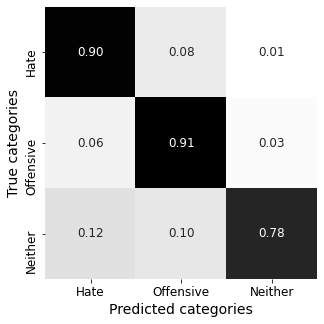

In [39]:
conf_matrix = confusion_matrix(y_test, tomek_logreg_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [117]:
tomek_logreg_precision = precision_score(y_test, tomek_logreg_test_preds,average='weighted')
tomek_logreg_recall = recall_score(y_test, tomek_logreg_test_preds,average='weighted')
tomek_logreg_f1_score = f1_score(y_test, tomek_logreg_test_preds,average='weighted')


# printing scores
evaluation(tomek_logreg_precision, tomek_logreg_recall, tomek_logreg_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.892
Recall: 0.892
F1 Score: 0.892


In [138]:
# adding scores to metric_dict

metric_dict['Logistic Regression - TOMEK'] = {'Precision': tomek_logreg_precision, 'Recall': tomek_logreg_recall, 'F1_score': tomek_logreg_f1_score}

### Grid Search 

In [112]:
# creating the model
baseline_model = LogisticRegression(class_weight='balanced', random_state=50)

In [113]:
# creating param_dict
param_dict={'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'newton-cg', 'sag'], 'C':
[100, 10, 1.0, 0.1, 0.01]}

In [114]:
# instantiate Grid Search CV with F1 metric
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='weighted')
grid_baseline = GridSearchCV(baseline_model, param_dict, cv=5, scoring= f1, verbose=1)

In [115]:
# fit the grid search to our data
grid_baseline.fit(tfidf_data_train, y_train)

# generate score with .best_score_ and hyperparemeters with .best_params_
print('F1 Score:', grid_baseline.best_score_)
print('Best Hyperparameters:', grid_baseline.best_params_)
print('Model object with best parameters: ')
print(grid_baseline.best_estimator_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   53.5s finished


F1 Score: 0.8969690132363489
Best Hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Model object with best parameters: 
LogisticRegression(class_weight='balanced', random_state=50, solver='liblinear')


In [116]:
grid_base_test_preds = grid_baseline.best_estimator_.predict(tfidf_data_test)

grid_base_logreg_report = classification_report(y_test, grid_base_test_preds)
print(grid_base_logreg_report)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      2162
           1       0.95      0.88      0.91      3884
           2       0.73      0.88      0.80       819

    accuracy                           0.89      6865
   macro avg       0.84      0.89      0.86      6865
weighted avg       0.89      0.89      0.89      6865



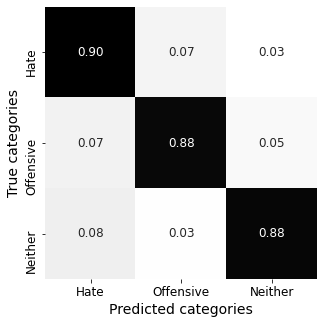

In [121]:
conf_matrix = confusion_matrix(y_test, grid_base_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [122]:
grid_logreg_precision = precision_score(y_test, grid_base_test_preds,average='weighted')
grid_logreg_recall = recall_score(y_test, grid_base_test_preds,average='weighted')
grid_logreg_f1_score = f1_score(y_test, grid_base_test_preds,average='weighted')


# printing scores
evaluation(grid_logreg_precision, grid_logreg_recall, grid_logreg_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.893
Recall: 0.885
F1 Score: 0.887


In [139]:
# adding scores to metric_dict

metric_dict['Logistic Regression - Grid Search'] = {'Precision': grid_logreg_precision, 'Recall': grid_logreg_recall, 'F1_score': grid_logreg_f1_score}

### Running This Tuned Baseline on SMOTE Data

In [125]:
# best model according to grid search
smote_tuned = LogisticRegression(C=1.0, class_weight='balanced', penalty='l1', random_state=50,
                   solver='liblinear')

smote_tuned.fit(smote_X_train, smote_y_train)
smote_tuned_test_preds = smote_tuned.predict(tfidf_data_test)

smote_tuned_logreg_report = classification_report(y_test, smote_tuned_test_preds)
print(smote_tuned_logreg_report)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      2162
           1       0.96      0.87      0.91      3884
           2       0.70      0.91      0.79       819

    accuracy                           0.88      6865
   macro avg       0.83      0.89      0.85      6865
weighted avg       0.89      0.88      0.88      6865



### Running This Tuned Baseline on TOMEK Data

In [126]:
tomek_tuned = LogisticRegression(C=1.0, class_weight='balanced', penalty='l1', random_state=50,
                   solver='liblinear')
tomek_tuned.fit(tomek_X_train, tomek_y_train)
tomek_tuned_test_preds = tomek_tuned.predict(tfidf_data_test)
tomek_tuned_logreg_report = classification_report(y_test, tomek_tuned_test_preds)
print(tomek_tuned_logreg_report)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2162
           1       0.96      0.88      0.91      3884
           2       0.76      0.88      0.81       819

    accuracy                           0.89      6865
   macro avg       0.85      0.89      0.87      6865
weighted avg       0.89      0.89      0.89      6865



### Baseline Naive Bayes

In [85]:
baseline_bayes = MultinomialNB(alpha = .01)

baseline_bayes.fit(tfidf_data_train, y_train)
bayes_test_preds = baseline_bayes.predict(tfidf_data_test)

bayes_baseline_report = classification_report(y_test, bayes_test_preds)
print(bayes_baseline_report)

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      2162
           1       0.84      0.90      0.87      3884
           2       0.77      0.41      0.54       819

    accuracy                           0.82      6865
   macro avg       0.80      0.71      0.74      6865
weighted avg       0.82      0.82      0.81      6865



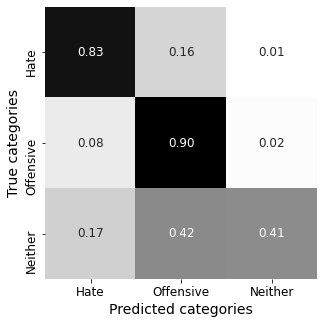

In [86]:
confusion_matrix = confusion_matrix(y_test, bayes_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [88]:
bayes_precision = precision_score(y_test, bayes_test_preds, average='weighted')
bayes_recall = recall_score(y_test, bayes_test_preds, average='weighted')
bayes_f1_score = f1_score(y_test, bayes_test_preds, average='weighted')

# printing scores
evaluation(bayes_precision, bayes_recall, bayes_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.817
Recall: 0.82
F1 Score: 0.812


In [140]:
# adding scores to metric_dict

metric_dict['Baseline Naive Bayes'] = {'Precision': bayes_precision, 'Recall': bayes_recall, 'F1_score': bayes_f1_score}

### Baseline SVM

In [40]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

SVM_baseline.fit(tfidf_data_train, y_train)
SVM_test_preds = SVM_baseline.predict(tfidf_data_test)

SVM_baseline_report = classification_report(y_test, SVM_test_preds)
print(SVM_baseline_report)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2162
           1       0.96      0.88      0.92      3884
           2       0.76      0.89      0.82       819

    accuracy                           0.89      6865
   macro avg       0.85      0.90      0.87      6865
weighted avg       0.90      0.89      0.89      6865



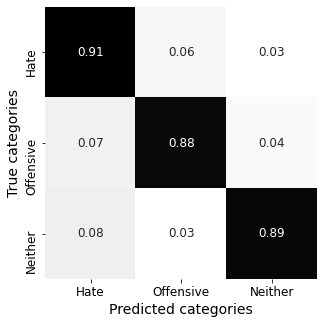

In [41]:
conf_matrix = confusion_matrix(y_test, SVM_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [127]:
SVM_precision = precision_score(y_test, SVM_test_preds, average='weighted')
SVM_recall = recall_score(y_test, SVM_test_preds, average='weighted')
SVM_f1_score = f1_score(y_test, SVM_test_preds, average='weighted')


# printing scores
evaluation(SVM_precision, SVM_recall, SVM_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.9
Recall: 0.893
F1 Score: 0.894


In [141]:
# adding scores to metric_dict
metric_dict['Baseline SVM'] = {'Precision': SVM_precision, 'Recall': SVM_recall, 'F1_score': SVM_f1_score}

### Basiline with SMOTE

In [42]:
smote_svm =svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

smote_svm.fit(smote_X_train, smote_y_train)
smote_svm_test_preds = smote_svm.predict(tfidf_data_test)

smote_svm_report = classification_report(y_test, smote_svm_test_preds)
print(smote_svm_report)


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2162
           1       0.95      0.89      0.92      3884
           2       0.73      0.89      0.81       819

    accuracy                           0.89      6865
   macro avg       0.85      0.89      0.87      6865
weighted avg       0.90      0.89      0.89      6865



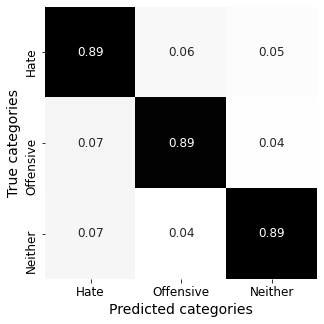

In [43]:
conf_matrix = confusion_matrix(y_test, smote_svm_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [128]:
smote_svm_precision = precision_score(y_test, smote_svm_test_preds, average='weighted')
smote_svm_recall = recall_score(y_test, smote_svm_test_preds, average='weighted')
smote_svm_f1_score = f1_score(y_test, smote_svm_test_preds, average='weighted')


# printing scores
evaluation(smote_svm_precision, smote_svm_recall,smote_svm_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.896
Recall: 0.889
F1 Score: 0.891


In [142]:
# adding scores to metric_dict
metric_dict['SVM - SMOTE'] = {'Precision': smote_svm_precision, 'Recall': smote_svm_recall, 'F1_score': smote_svm_f1_score}

### Baseline with Tomek Links¶

In [44]:
tomek_svm = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

tomek_svm.fit(tomek_X_train, tomek_y_train)
tomek_svm_test_preds = tomek_svm.predict(tfidf_data_test)

tomek_svm_report = classification_report(y_test, tomek_svm_test_preds)
print(tomek_svm_report)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2162
           1       0.96      0.88      0.92      3884
           2       0.75      0.89      0.81       819

    accuracy                           0.89      6865
   macro avg       0.85      0.90      0.87      6865
weighted avg       0.90      0.89      0.89      6865



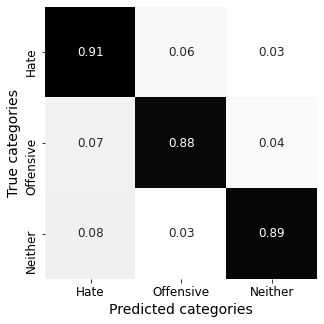

In [45]:
conf_matrix = confusion_matrix(y_test, tomek_svm_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [130]:
tomek_svm_precision = precision_score(y_test, tomek_svm_test_preds, average='weighted')
tomek_svm_recall = recall_score(y_test, tomek_svm_test_preds, average='weighted')
tomek_svm_f1_score = f1_score(y_test, tomek_svm_test_preds, average='weighted')


# printing scores
evaluation(tomek_svm_precision, tomek_svm_recall,tomek_svm_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.9
Recall: 0.892
F1 Score: 0.894


In [143]:
# adding scores to metric_dict
metric_dict['SVM - TOMEK'] = {'Precision': tomek_svm_precision, 'Recall': tomek_svm_recall, 'F1_score': tomek_svm_f1_score}

### Evaluation Metrics for All Baseline Models

In [144]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,Precision,Recall,F1_score
Baseline Random Forest,0.886601,0.885361,0.885877
Baseline Logistic Regression,0.893245,0.883321,0.885491
Logistic Regression - SMOTE,0.890942,0.881865,0.884017
Logistic Regression - TOMEK,0.892493,0.891770,0.891837
Logistic Regression - Grid Search,0.892795,0.885361,0.887077
Baseline Naive Bayes,0.817145,0.820393,0.811553
Baseline SVM,0.899727,0.892644,0.894191
SVM - SMOTE,0.896126,0.889002,0.890805
SVM - TOMEK,0.899830,0.892498,0.894142


Overall, the Tuned Baseline SVM model performed the best across weighted recall(0.89) and weighted F1(0.89). 

In [145]:
# Pickling final model for the interactive webapp
import pickle
pickle_out = open("svm_model.pkl","wb")
pickle.dump(SVM_baseline, pickle_out)
pickle_out.close()

In [146]:
## pickling X_train for future use
pickle_out = open("X_train.pkl","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()